In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns
import numpy as np
import glob
import matplotlib.pyplot as plt
import math
from Bio import SeqIO
import matplotlib as mpl
from matplotlib.pyplot import figure
from scipy.stats import pearsonr

**Note: QOSTED is used synomously with MST in some of the code below.**

# Find best parameters across all trees

In [2]:
df = pd.read_csv('out/mles_and_params.csv')
df['offset'] = df['offset']/1.947 # 1.947 REU to kcalRos/kcal for ddG according to data in (Park ... DiMaio, 2016, JCTC)
df['p_transition'] = -df['p_transition']
df.sort_values(by='mle', ascending=False).head()

,Unnamed: 0,params,mle,N,p_transition,offset,kappa
9168,9168,3.8_11.5_1.0_2.1_10.0,-13664.936423,3.8,-1.0,5.906523,2.1
8628,8628,3.8_11.5_1.0_2.0_10.0,-13665.069827,3.8,-1.0,5.906523,2.0
10017,10017,3.8_11.5_1.0_2.2_10.0,-13665.259308,3.8,-1.0,5.906523,2.2
3594,3594,4.2_12.5_1.0_2.1_10.0,-13665.269923,4.2,-1.0,6.420134,2.1
16145,16145,4.0_12.0_1.0_2.0_10.0,-13665.329404,4.0,-1.0,6.163328,2.0


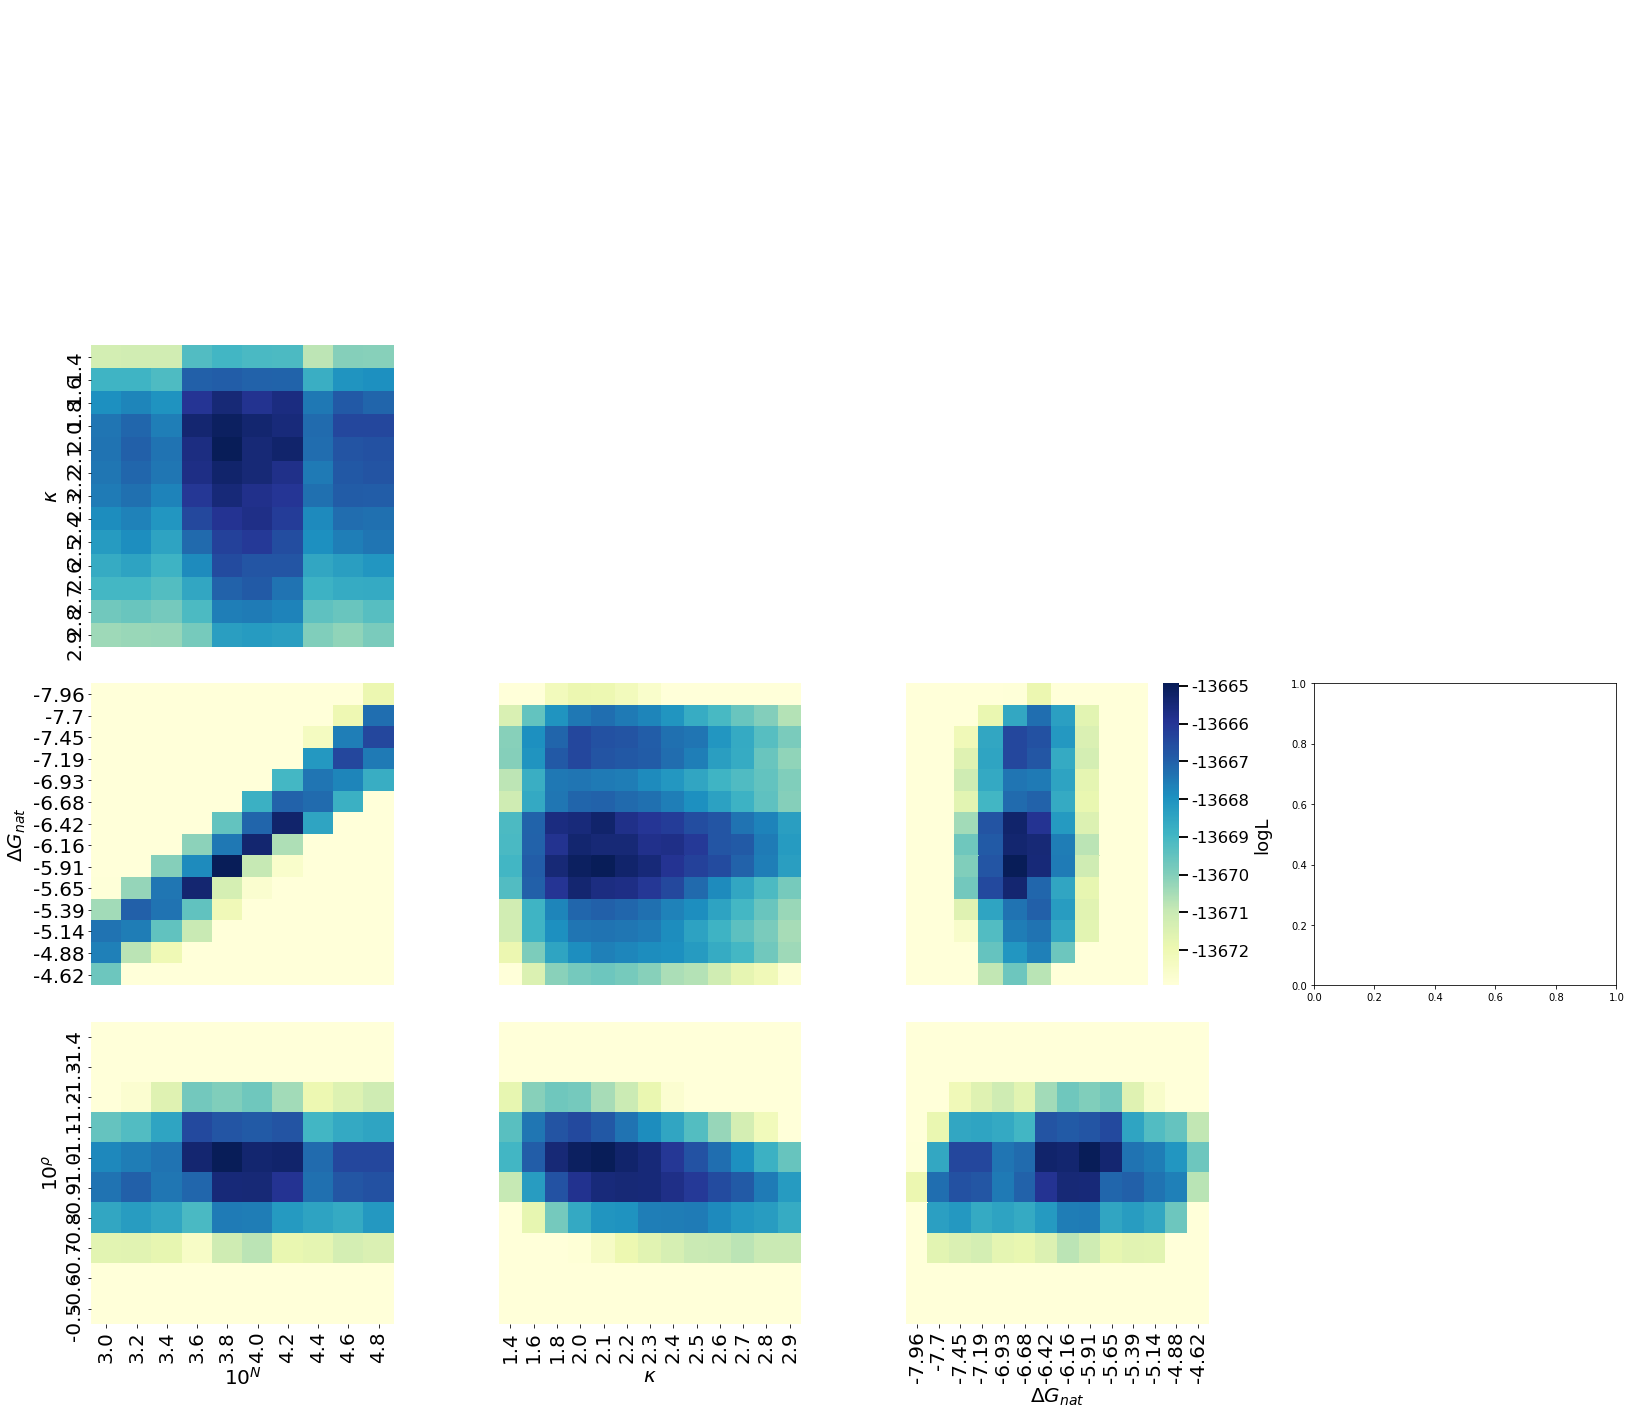

In [3]:
import matplotlib.ticker as tkr
(fig, axs) = plt.subplots(
    ncols=4, nrows=4, figsize=[23,20]
)
df_tmp = df.copy()
df_tmp['offset'] = -np.round(df_tmp['offset'],2)
df_tmp = df_tmp[df_tmp['offset']>-8.21]

relevant_features = ['N', 'kappa', 'offset', 'p_transition']
interpretable_labels = ['$10^{N}$', '$κ$', '$\Delta G_{nat}$' ,'$10^{ρ}$']
 
ticks = {'kappa': [], 
         'offset': [],
         'N': np.arange(3.0, 5.0, 0.2),
         'p_transition':[]}

sns.set_context("talk") 

for i,(f1,l1) in enumerate(zip(relevant_features,interpretable_labels)):
    for j,(f2,l2) in enumerate(zip(relevant_features,interpretable_labels)):
        if i>j or (j==3 and i==2):
            # Many parameter per pairbin per bin. Plot max logL
            x = df_tmp.sort_values(by='mle', ascending=False)
            x = x.drop_duplicates(subset=[f1,f2])              
            heatmap1_data = pd.pivot_table(x, values='mle', 
                     index=f1, 
                     columns=f2)
            formatter = '%.0f'
            is_max = True
            heatmap1_data = heatmap1_data.fillna(-1e8) 
            
            xlabels = [] if i!= 3 else heatmap1_data.columns
            ylabels = [] if j!= 0 else heatmap1_data.index
            
            
            make_cbar = True if (j==3 and i==2) else False
            if (j==3 and i==2):
                g = sns.heatmap(heatmap1_data, cbar=make_cbar, ax=axs[2,2], cmap="YlGnBu", cbar_kws={"format": formatter, 'label':'logL'},
                                 vmin=np.max(df_tmp['mle'])-8, vmax=np.max(df_tmp['mle']), xticklabels=xlabels, yticklabels=ylabels)
            else:
                g = sns.heatmap(heatmap1_data, cbar=make_cbar, ax=axs[i,j], cmap="YlGnBu", cbar_kws={"format": formatter, 'label':'logL'},
                                 vmin=np.max(df_tmp['mle'])-8, vmax=np.max(df_tmp['mle']), xticklabels=xlabels, yticklabels=ylabels)


            
            g.set_xlabel(l2, fontsize=20) if i==3 else g.set_xlabel('')
            g.set_ylabel(l1, fontsize=20) if j==0 else g.set_ylabel('')
            g.set_yticklabels(g.get_yticklabels(), fontsize=20)
            g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=20)        
        else:
            axs[i,j].axis('off')

plt.tight_layout()
plt.savefig('figs/logL_heatmap.pdf')

# Parameter uncertainty estimation by bootstrap

In [4]:
# Get all the data into one dataframe
dfs = []
for i, row in df.iterrows():   
    # add to df
    f = f"mles/E2Q_{row['params']}/E2Q_{row['params']}.mles"
    dfx = pd.read_csv(f, delim_whitespace=True)
    dfx = dfx[dfx['mle']!='fail']
    dfx = dfx[dfx['mle']!='mle']
    dfx['offset'] = row['offset']
    dfx['N'] = row['N']
    dfx['p_transition'] = row['p_transition']
    dfx['kappa'] = row['kappa']
    assert len(dfx) == 52
    dfs.append(dfx)
df_combined = pd.concat(dfs)
df_combined.to_csv('out/mles_all_trees_all_parameters.csv')

In [5]:
df_mles = pd.read_csv('out/mles_all_trees_all_parameters.csv')
df_mles['params'] = df_mles['offset'].astype(str) + '_' + df_mles['N'].astype(str) + '_' + df_mles['p_transition'].astype(str) + '_' + df_mles['kappa'].astype(str)

In [6]:
# Run bootstrap
rerun_bootstrap = False
if rerun_bootstrap:
    with open('cmds_bootstrap', 'w') as f_out:
        for i in range(0,10000):
            cmd = f'python bootstrap_parameter_distribution.py > bootstrap_samples/{i}.txt'
            f_out.write(cmd+'\n')

In [7]:
%cat bootstrap_samples/* > bootstrap_samples/combined.dat

cat: bootstrap_samples/combined.dat: input file is output file


In [8]:
df_resampling10 = pd.read_csv('bootstrap_samples/combined.dat', delim_whitespace=True, names=['offset', 'N','p_transition','kappa'])

parameter mean stdev
offset 5.95 0.12
N 3.83 0.09
p_transition -0.97 0.05
kappa 2.08 0.12


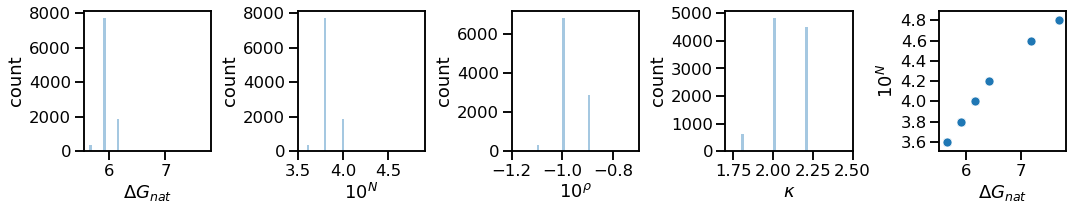

In [9]:
# Plot 1D
(fig, axs) = plt.subplots(
    ncols=5, nrows=1, figsize=[15,3]
)
axs = axs.reshape(-1)
relevant_features = df_resampling10.columns
interpretable_labels = ['$\Delta G_{nat}$', '$10^{N}$', '$10^{ρ}$', '$κ$']
sns.set_context('talk')
for i,(f1,l1) in enumerate(zip(relevant_features,interpretable_labels)):
    vmin = min(df_resampling10[f1])
    vmax = max(df_resampling10[f1])
    
    sns.distplot(df_resampling10[f1],ax=axs[i],kde=False)
    axs[i].set_xlabel(l1)
    axs[i].set_ylabel('count')
    axs[i].set_xlim([vmin-0.1,vmax+0.1])

sns.scatterplot(df_resampling10['offset'],df_resampling10['N'], ax=axs[4])
axs[4].set_xlabel('$\Delta G_{nat}$')
axs[4].set_ylabel('$10^{N}$')
sns.set_context('paper')
plt.tight_layout()

print("parameter mean stdev")
for p in df_resampling10.columns:
    print(p, np.round(np.mean(df_resampling10[p]),2), np.round(np.std(df_resampling10[p]),2))

# Compute MLE for an independent set of trees using both LG and best Q

In [10]:
exe = '/home/norn/software/iqtree-1.6.12-Linux/bin/iqtree'
rerun_pfam_logL_calculations = False
if rerun_pfam_logL_calculations:
    commands = 'cmds_test_alns'
    with open(commands,'w') as f_out:
        for q_matrix in ['LG', 'q_matrices/E2Q_3.8_11.5_1.0_2.1_10.0.paml']:
            for phylip_f in glob.glob('lg_PfamTestingAlignments/*phyml'):
                outid_q = 'LG' if q_matrix=='LG' else 'QOSTED'
                phy_id = phylip_f.split('/')[-1]
                cmd = f'{exe} -s {phylip_f} -st AA -m {q_matrix}+FO+G4 -redo --no-outfiles | grep "BEST SCORE FOUND" > lg_PfamTestingAlignments/{outid_q}_{phy_id}.mle'
                f_out.write(cmd+'\n')
    # Execute the commands in cmds_test_alns (distributed computing recommended)

In [11]:
d = {'aln':[], 'logL_QOSTED':[], 'logL_lG':[]}
for f in glob.glob('lg_PfamTestingAlignments/*phyml'):
    fm1 = f.split('/')[-1]

    qosted_mle_f = 'lg_PfamTestingAlignments/'+'QOSTED_'+fm1+'.mle'
    df = pd.read_csv(qosted_mle_f,delim_whitespace=True, names=['x1','x2','x3','x4','logL'])
    d['logL_QOSTED'].append(df.iloc[0]['logL'])
    
    lg_mle_f = 'lg_PfamTestingAlignments/'+'LG_'+fm1+'.mle'
    df = pd.read_csv(lg_mle_f,delim_whitespace=True, names=['x1','x2','x3','x4','logL'])
    d['logL_lG'].append(df.iloc[0]['logL'])

    d['aln'].append(fm1)
df_mle_holdout = pd.DataFrame.from_dict(d)

,aln,logL_QOSTED,logL_lG,delta_logL
372,Aln2393.txt-gb_phyml,-577.403,-590.073,-12.670
65,Aln6612.txt-gb_phyml,-2493.606,-2500.485,-6.879
151,Aln3459.txt-gb_phyml,-3494.576,-3499.601,-5.025
222,Aln3653.txt-gb_phyml,-1272.407,-1276.997,-4.590
337,Aln5878.txt-gb_phyml,-950.257,-954.827,-4.570


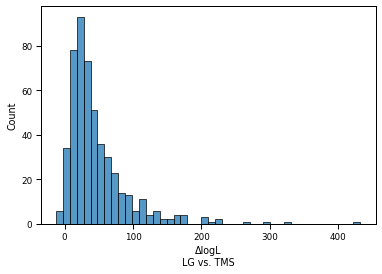

In [12]:
df_mle_holdout['delta_logL'] = df_mle_holdout['logL_lG']-df_mle_holdout['logL_QOSTED']
sns.histplot(df_mle_holdout['delta_logL'], label='dlogL')
x = df_mle_holdout[df_mle_holdout['delta_logL']<=5]
x = x.sort_values(by='delta_logL')
plt.xlabel('ΔlogL\nLG vs. TMS')
with open('out/logL_trees_better_than_5.html', 'w') as f_out:
    f_out.write(x.to_html())
display(x.head())

# Make the bubble plots for LG vs. MLE optimize TMS

In [13]:
def Q2R(Q20):
    # Set row sum
    d_index = np.diag_indices(20)
    Q20[d_index] = 0.0
    row_sums = np.nansum(Q20, axis=1)
    Q20[d_index] = -row_sums

    # Find pi and norm the matrix
    pi = np.ones(20).dot(np.linalg.inv(Q20 + np.ones((20, 20))))
    relative_rate = -np.sum([Q20[i][i] * pi[i] for i in range(0, 20)])
    Q20_normed = Q20 / relative_rate

    R_asym = Q20_normed / pi
    R_sym = (R_asym + R_asym.T) / 2
    return R_sym


def read_paml_ratemat_file(rrfile):
    R = np.zeros((20,20))
    pi = np.zeros(20)
    modelname = ''
    with open(rrfile, 'r') as f_open:
        for line_i, line in enumerate(f_open):
            if 'model' in line:
                modelname = line.split()[-1].replace('=','')
                if '.' in modelname:
                    modelname = modelname.split('.')[-1]
                continue
            
            if line_i>20:
                break
            try:            
                data = line.split()
            except:
                continue
            if len(data)<20:
                R[len(data),0:len(data)] = data
            else:
                pi = np.array([float(x) for x in line.split()])
                pi = pi/pi.sum()
    
    # Symmetrize
    for i in range(0,20):
        for j in range(i,20):
            R[i][j] = R[j][i]
            
    # Diagonalize LG freq_vector
    diag_freq = np.zeros((20, 20))
    d_index = np.diag_indices(20)
    diag_freq[d_index] = pi

    # Find LG Q
    Q = np.dot(R, diag_freq)
    # 1) Set the diagonal, so that the rows sum to 0
    # 2) find the normalizing constant
    norm_constant = 0
    for i in range(0, 20):
        Q[i][i] = -np.sum(Q[i][:])
        norm_constant -= Q[i][i] * pi[i]
        
    # normalize Q
    Q = Q / norm_constant
    
    R = Q2R(Q)

    return R, pi, Q, modelname

def normalize_Rmat(R):
    newR = np.zeros((20,20))
    scale = 0.0
    for i in range(0,20):
        for j in range(i,20):
            if i!=j:
                scale += R[i][j]
    scale /= 190
    for i in range(0,20):
        for j in range(0,20):
            newR[i][j] = R[i][j]/scale
    return newR

def plot_matrix(np_matrix, set_color='', 
                plot_title=True, ignore_negatives=True,
                set_scale=None, half_matrix=False,
                exclude_diagonal=True, xlabel='',
                ylabel='', outfile_name=''):
    
#     font = {'family': 'normal',
#             'weight': 'bold',
#             'size': 14}
#     mpl.rc('font', **font)
    
    aas_nostop = list('ARNDCQEGHILKMFPSTWYV')
    aas_list = [x for x in aas_nostop]
    aas_list_rev = list(reversed(aas_list))


    if ignore_negatives:
        scale = np.mean([x for x in np_matrix.flatten() if x > 0])
    else:
        scale = np_matrix.mean()

    if set_scale is None:
        np_matrix = normalize_Rmat(np_matrix)
        scale = 1.0
    else:
        scale = set_scale

    X = []
    Y = []
    sizes = []
    colors = []

    for i in range(0,20):
        if half_matrix:
            start_from = i
        else:
            start_from = 0
        for j in range(start_from, 20):
            if exclude_diagonal and i==j:
                continue
            s = np_matrix[i][j] * 1/scale * 30
            X.append(i)
            Y.append(19-j)
            sizes.append(np.fabs(s))
            if set_color == '':
                if s < 0:
                    colors.append('red')
                else:
                    colors.append('blue')
            if set_color != '':
                colors.append(set_color)

    plt.scatter(X, Y, s=sizes, facecolor='None', edgecolors=colors, linewidths=1)
    plt.xlim(-1,20)
    plt.ylim(-1,20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(range(0,20), aas_list)
    plt.yticks(range(0,20), aas_list_rev)
    #plt.grid()

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

3.8_11.5_1.0_2.1_10.0
q_matrices/E2Q_3.8_11.5_1.0_2.1_10.0.paml
----------------------------------------------------------------------------------
WAG
Q-matrix correlation 0.6737180036270508
R-matrix correlation 0.6707822539560173
pi-matrix correlation 0.3890687907589258

TMS WY: 2.8675167933326264
WAG WY: 2.6084532816309896
underrep: 0.909655799643791

TMS NF: 0.11691179569654714
WAG NF: 0.10092353526549999
overrep: 1.1584195439546063
----------------------------------------------------------------------------------
LG
Q-matrix correlation 0.6295586962525306
R-matrix correlation 0.6416602486858342
pi-matrix correlation 0.6468497477323547

TMS WY: 2.8675167933326264
WAG WY: 3.1518123348524236
underrep: 1.0991434617508862

TMS NF: 0.11691179569654714
WAG NF: 0.08952492429843009
overrep: 1.3059133711950797


<Figure size 432x288 with 0 Axes>

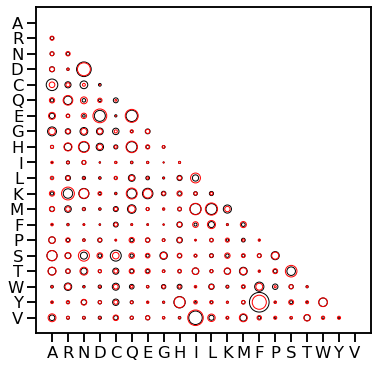

<Figure size 432x288 with 0 Axes>

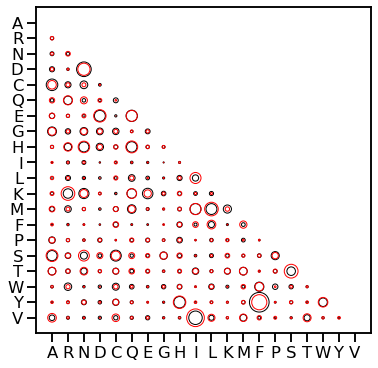

In [14]:
# Bubble plot
dfm = pd.read_csv('out/mles_and_params.csv')
dfm = dfm.sort_values(by='mle', ascending=False)
bestp = list(dfm['params'])[0]
print(bestp)
best_q = f'q_matrices/E2Q_{bestp}.paml'
print(best_q)
fit_R, fit_pi, fit_Q, _ = read_paml_ratemat_file(best_q)

native_matrix_fs = ['alternative_q_matrices/iqtree/F6.dat', 'alternative_q_matrices/iqtree/F26.dat']
native_matrix_names = ['WAG', 'LG']
sns.set_context('talk')
for q_f, q_name in zip(native_matrix_fs, native_matrix_names):
    LG_R, LG_pi, LG_Q, _ = read_paml_ratemat_file(q_f)
    plt.figure()
    figure(figsize=(6, 6))
    # Plot bubbles
    print('----------------------------------------------------------------------------------')
    print(q_name)
    plot_matrix(fit_R, set_color='black', half_matrix=True)
    plot_matrix(LG_R, set_color='red', half_matrix=True)
    #sns.despine()
    plt.savefig(f'figs/opt_params_vs_mle_{q_name}.pdf', dpi=300)
    
    # Get correlations
    half_fit_Q = [fit_Q[i,j] for i in range(0,20) for j in range(0,20) if i!=j]
    half_fit_R = [fit_R[i,j] for i in range(0,20) for j in range(i,20) if i!=j]

    half_LG_Q = [LG_Q[i,j] for i in range(0,20) for j in range(0,20) if i!=j]
    half_LG_R = [LG_R[i,j] for i in range(0,20) for j in range(i,20) if i!=j]
    
    print(f'Q-matrix correlation {pearsonr(np.log(half_fit_Q), np.log(half_LG_Q))[0]**2}')
    print(f'R-matrix correlation {pearsonr(np.log(half_fit_R), np.log(half_LG_R))[0]**2}')
    print(f'pi-matrix correlation {pearsonr(LG_pi, fit_pi)[0]**2}')
    print('')
    print(f'TMS WY: {fit_R[17,18]}')
    print(f'WAG WY: {LG_R[17,18]}')
    print(f'underrep: {LG_R[17,18]/fit_R[17,18]}')
    print('')
    print(f'TMS NF: {fit_R[2,13]}')
    print(f'WAG NF: {LG_R[2,13]}')
    print(f'overrep: {fit_R[2,13]/LG_R[2,13]}')

WAG, R^2=0.67
LG, R^2=0.64


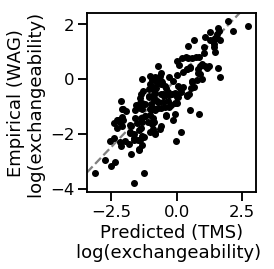

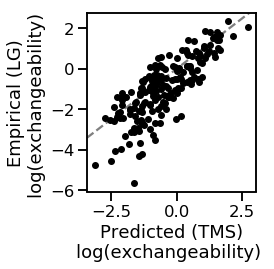

In [15]:
# Plot correlation for R
native_matrix_fs = ['alternative_q_matrices/iqtree/F6.dat', 'alternative_q_matrices/iqtree/F26.dat']
native_matrix_names = ['WAG', 'LG']
is_log = True
for q_f, q_name in zip(native_matrix_fs, native_matrix_names):
    LG_R, LG_pi, LG_Q, _ = read_paml_ratemat_file(q_f)
    
    half_fit_R = [fit_R[i,j] for i in range(0,20) for j in range(i,20) if i!=j]
    half_LG_R = [LG_R[i,j] for i in range(0,20) for j in range(i,20) if i!=j]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    half_fit_R = np.log(half_fit_R) if is_log else half_fit_R
    half_LG_R = np.log(half_LG_R) if is_log else half_LG_R
    lbl = 'log(exchangeability)' if is_log else 'exchangeability'
    ax.scatter(half_fit_R, half_LG_R, color='black', s=30, zorder=10)
    add_identity(ax, color='grey', ls='--', zorder=0)
    plt.xlabel(f'Predicted (TMS)\n{lbl} ')
    plt.ylabel(f'Empirical ({q_name})\n{lbl} ')
    plt.minorticks_off()
    #plt.yticks([-6,-4,-2])
    #plt.xticks([-6,-4,-2])
    plt.tight_layout()
    sns.set_context('talk')
    
    plt.savefig(f'figs/opt_params_vs_mle_scatter_{q_name}.pdf', transparent=True, dpi=300)
    
    print(f'{q_name}, R^2={np.round(pearsonr(half_fit_R, half_LG_R)[0]**2,2)}')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


--------------------------------------
Stationary frequency WAG, 0.39
Predicted freq for C: 0.005
Actual freq for C: 0.019
underep C: 4.161
--------------------------------------
Stationary frequency LG, 0.65
Predicted freq for C: 0.005
Actual freq for C: 0.013
underep C: 2.788


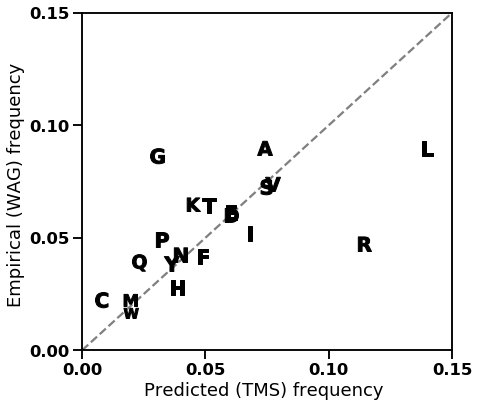

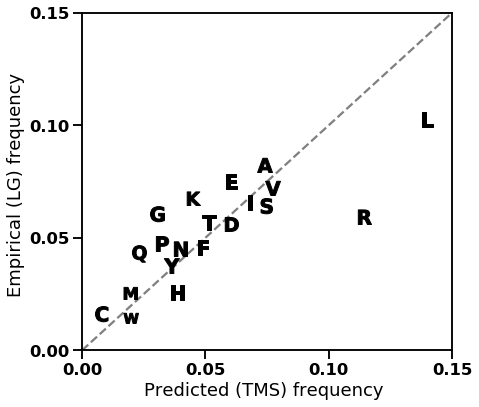

In [16]:
# plot correlations for pi


font = {'family': 'normal',
        'weight': 'bold',
        'size': 20}
mpl.rc('font', **font)
from matplotlib.text import TextPath
aas = 'ARNDCQEGHILKMFPSTWYV'
sns.set_context('talk')
for q_f, q_name in zip(native_matrix_fs, native_matrix_names):
    LG_R, LG_pi, LG_Q, _ = read_paml_ratemat_file(q_f)
    fig, ax = plt.subplots(figsize=(7, 6))
    
    for i,aa in enumerate(list(aas)):
        p = TextPath((0,0), aa)
        ax.plot(fit_pi[i], LG_pi[i],
                   zorder=10, 
                   marker=p, markersize=30, color='black') # marker=r"$ {} $".format(aa)
    add_identity(ax, color='grey', ls='--', zorder=0)
    plt.xlim([0, 0.15])
    plt.ylim([0, 0.15])
    y_ticks = plt.yticks([0,0.05,0.10,0.15])
    x_ticks = plt.xticks([0,0.05,0.10,0.15])
    
    
    plt.xlabel('Predicted (TMS) frequency ')
    plt.ylabel(f'Empirical ({q_name}) frequency ')
    plt.tight_layout()

    plt.savefig(f'figs/opt_params_vs_mle_scatter_pi_{q_name}.pdf', transparent=True)
    print('--------------------------------------')
    print(f'Stationary frequency {q_name}, {np.round(pearsonr(fit_pi, LG_pi)[0]**2,2)}')
    print(f'Predicted freq for C: {np.round(fit_pi[4],3)}')
    print(f'Actual freq for C: {np.round(LG_pi[4],3)}')
    print(f'underep C: {np.round(LG_pi[4]/fit_pi[4],3)}')
mpl.rcdefaults()


# Make bubble plots for LG vs. mutation-only

----------------------------------------------------------------------------------
WAG
Q-matrix correlation 0.46851289073994823
R-matrix correlation 0.428561066999769
pi-matrix correlation 0.4542550213887429

TMS WY: 0.4285878829762706
WAG WY: 2.6084532816309896
underrep: 6.086157320913831

TMS NF: 0.42858788297627437
WAG NF: 0.10092353526549999
overrep: 4.246659432299774
----------------------------------------------------------------------------------
LG
Q-matrix correlation 0.35695056041494266
R-matrix correlation 0.31438587409853674
pi-matrix correlation 0.431793065471247

TMS WY: 0.4285878829762706
WAG WY: 3.1518123348524236
underrep: 7.353946436761322

TMS NF: 0.42858788297627437
WAG NF: 0.08952492429843009
overrep: 4.787358228280458


<Figure size 640x480 with 0 Axes>

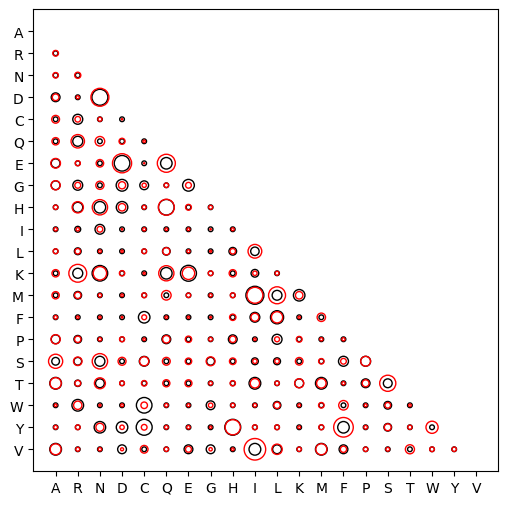

<Figure size 640x480 with 0 Axes>

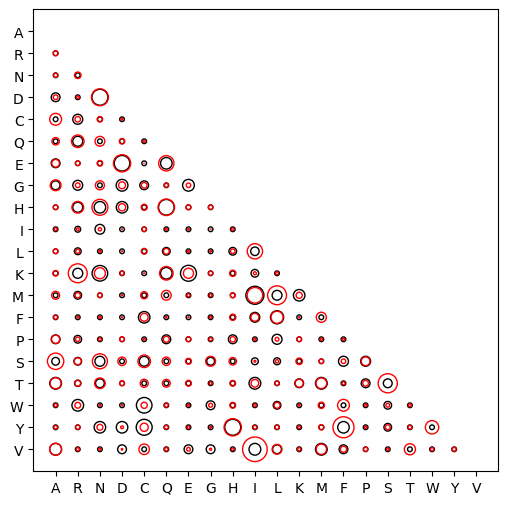

In [17]:
# Bubble plot
no_selection_Q = f'alternative_q_matrices/E2Q_0.0_0.0_1.0_2.1_10.0.paml'
fit_R, fit_pi, fit_Q, _ = read_paml_ratemat_file(no_selection_Q)

native_matrix_fs = ['alternative_q_matrices/iqtree/F6.dat', 'alternative_q_matrices/iqtree/F26.dat']
native_matrix_names = ['WAG', 'LG']
for q_f, q_name in zip(native_matrix_fs, native_matrix_names):
    LG_R, LG_pi, LG_Q, q_name = read_paml_ratemat_file(q_f)
    plt.figure()
    figure(figsize=(6, 6))
    # Plot bubbles
    print('----------------------------------------------------------------------------------')
    print(q_name)
    plot_matrix(fit_R, set_color='black', half_matrix=True)
    plot_matrix(LG_R, set_color='red', half_matrix=True)
    #sns.despine()
    plt.savefig(f'figs/nosel_vs_mle_{q_name}.pdf', dpi=300)
    
    # Get correlations
    half_fit_Q = [fit_Q[i,j] for i in range(0,20) for j in range(0,20) if i!=j]
    half_LG_Q = [LG_Q[i,j] for i in range(0,20) for j in range(0,20) if i!=j]
    
    half_fit_R = [fit_R[i,j] for i in range(0,20) for j in range(i,20) if i!=j]
    half_LG_R = [LG_R[i,j] for i in range(0,20) for j in range(i,20) if i!=j]
    
    print(f'Q-matrix correlation {pearsonr(np.log(half_fit_Q), np.log(half_LG_Q))[0]**2}')
    print(f'R-matrix correlation {pearsonr(np.log(half_fit_R), np.log(half_LG_R))[0]**2}')
    print(f'pi-matrix correlation {pearsonr(LG_pi, fit_pi)[0]**2}')
    print('')
    print(f'TMS WY: {fit_R[17,18]}')
    print(f'WAG WY: {LG_R[17,18]}')
    print(f'underrep: {LG_R[17,18]/fit_R[17,18]}')
    print('')
    print(f'TMS NF: {fit_R[2,13]}')
    print(f'WAG NF: {LG_R[2,13]}')
    print(f'overrep: {fit_R[2,13]/LG_R[2,13]}')

Correlation mutation only vs. WAG  0.43
Correlation mutation only vs. LG  0.31


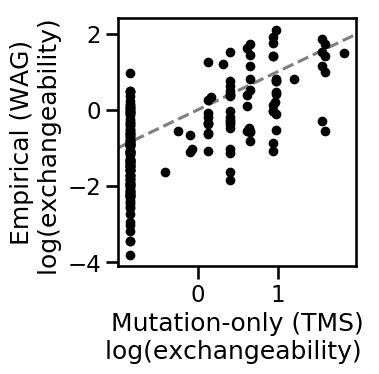

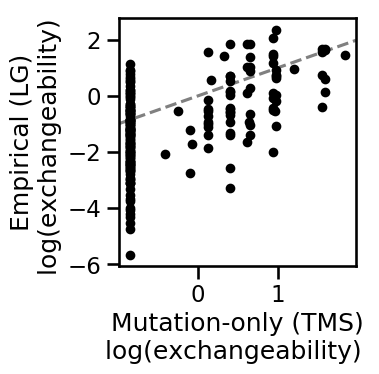

In [18]:
# Plot correlation for R
fit_R, fit_pi, fit_Q, _ = read_paml_ratemat_file(no_selection_Q)

native_matrix_fs = ['alternative_q_matrices/iqtree/F6.dat', 'alternative_q_matrices/iqtree/F26.dat']
native_matrix_names = ['WAG', 'LG']
sns.set_context('talk')
is_log = True
for q_f, q_name in zip(native_matrix_fs, native_matrix_names):
    LG_R, LG_pi, LG_Q, _ = read_paml_ratemat_file(q_f)
    
    half_fit_R = [fit_R[i,j] for i in range(0,20) for j in range(i,20) if i!=j]
    half_LG_R = [LG_R[i,j] for i in range(0,20) for j in range(i,20) if i!=j]
    half_fit_R = np.log(half_fit_R) if is_log else half_fit_R
    half_LG_R = np.log(half_LG_R) if is_log else half_LG_R
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(half_fit_R, half_LG_R, color='black', s=30, zorder=10)
    add_identity(ax, color='grey', ls='--', zorder=0)
    
    lbl = 'log(exchangeability)' if is_log else 'exchangeability'
    plt.xlabel(f'Mutation-only (TMS)\n{lbl} ')
    plt.ylabel(f'Empirical ({q_name})\n{lbl} ')
    plt.minorticks_off()
    #plt.yticks([-6,-4,-2])
    #plt.xticks([-6,-4,-2])
    plt.tight_layout()
    
    
    plt.savefig(f'figs/nosel_vs_mle_scatter_{q_name}.pdf', transparent=True, dpi=300)
    
    print(f'Correlation mutation only vs. {q_name}  {np.round(pearsonr(half_fit_R, half_LG_R)[0]**2,2)}')

--------------------------------------
Stationary frequency WAG, 0.45
Predicted freq for C: 0.033
Actual freq for C: 0.019
underep C: 0.589
--------------------------------------
Stationary frequency LG, 0.43
Predicted freq for C: 0.033
Actual freq for C: 0.013
underep C: 0.395


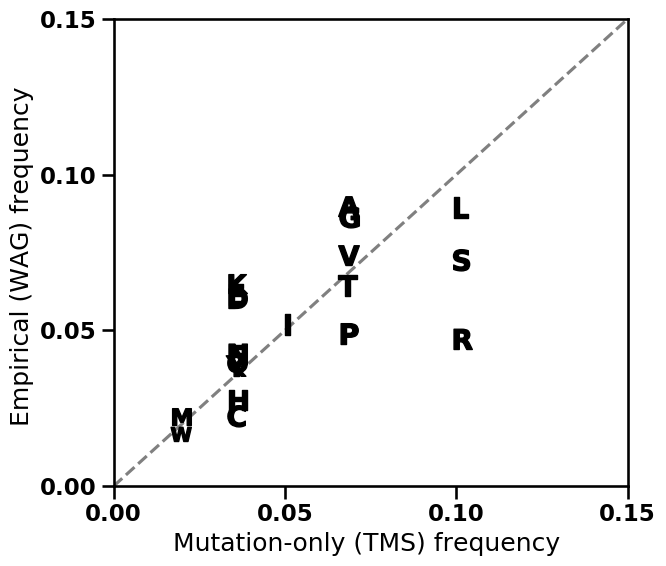

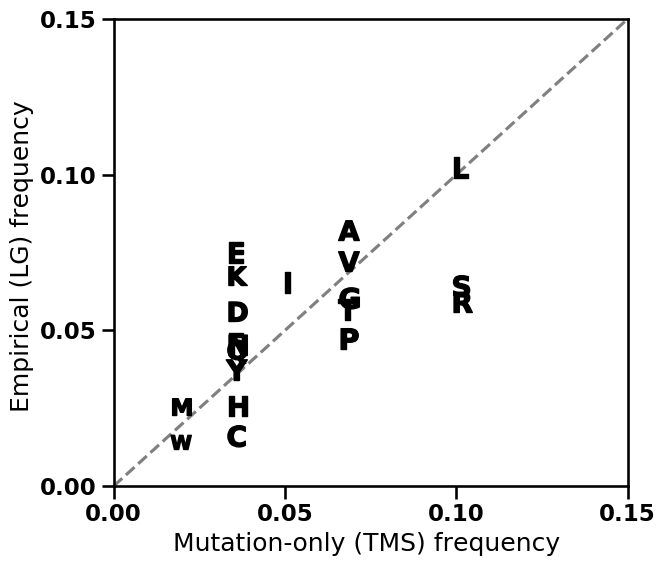

In [19]:
# plot correlations for pi
mpl.rcdefaults()

font = {'family': 'normal',
        'weight': 'bold',
        'size': 20}
mpl.rc('font', **font)
from matplotlib.text import TextPath
aas = 'ARNDCQEGHILKMFPSTWYV'
sns.set_context('talk')
for q_f, q_name in zip(native_matrix_fs, native_matrix_names):
    LG_R, LG_pi, LG_Q, _ = read_paml_ratemat_file(q_f)
    fig, ax = plt.subplots(figsize=(7, 6))
    
    for i,aa in enumerate(list(aas)):
        p = TextPath((0,0), aa)
        ax.plot(fit_pi[i], LG_pi[i],
                   zorder=10, 
                   marker=p, markersize=30, color='black') # marker=r"$ {} $".format(aa)
    add_identity(ax, color='grey', ls='--', zorder=0)
    plt.xlim([0, 0.15])
    plt.ylim([0, 0.15])
    y_ticks = plt.yticks([0,0.05,0.10,0.15])
    x_ticks = plt.xticks([0,0.05,0.10,0.15])
    
    
    plt.xlabel('Mutation-only (TMS) frequency ')
    plt.ylabel(f'Empirical ({q_name}) frequency ')
    plt.tight_layout()

    plt.savefig(f'figs/nosel_vs_mle_scatter_pi_{q_name}.pdf', transparent=True)
    print('--------------------------------------')
    print(f'Stationary frequency {q_name}, {np.round(pearsonr(fit_pi, LG_pi)[0]**2,2)}')
    print(f'Predicted freq for C: {np.round(fit_pi[4],3)}')
    print(f'Actual freq for C: {np.round(LG_pi[4],3)}')
    print(f'underep C: {np.round(LG_pi[4]/fit_pi[4],3)}')

# Compare between TMS and other Q-matrices

/software/conda/envs/pyrosetta/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


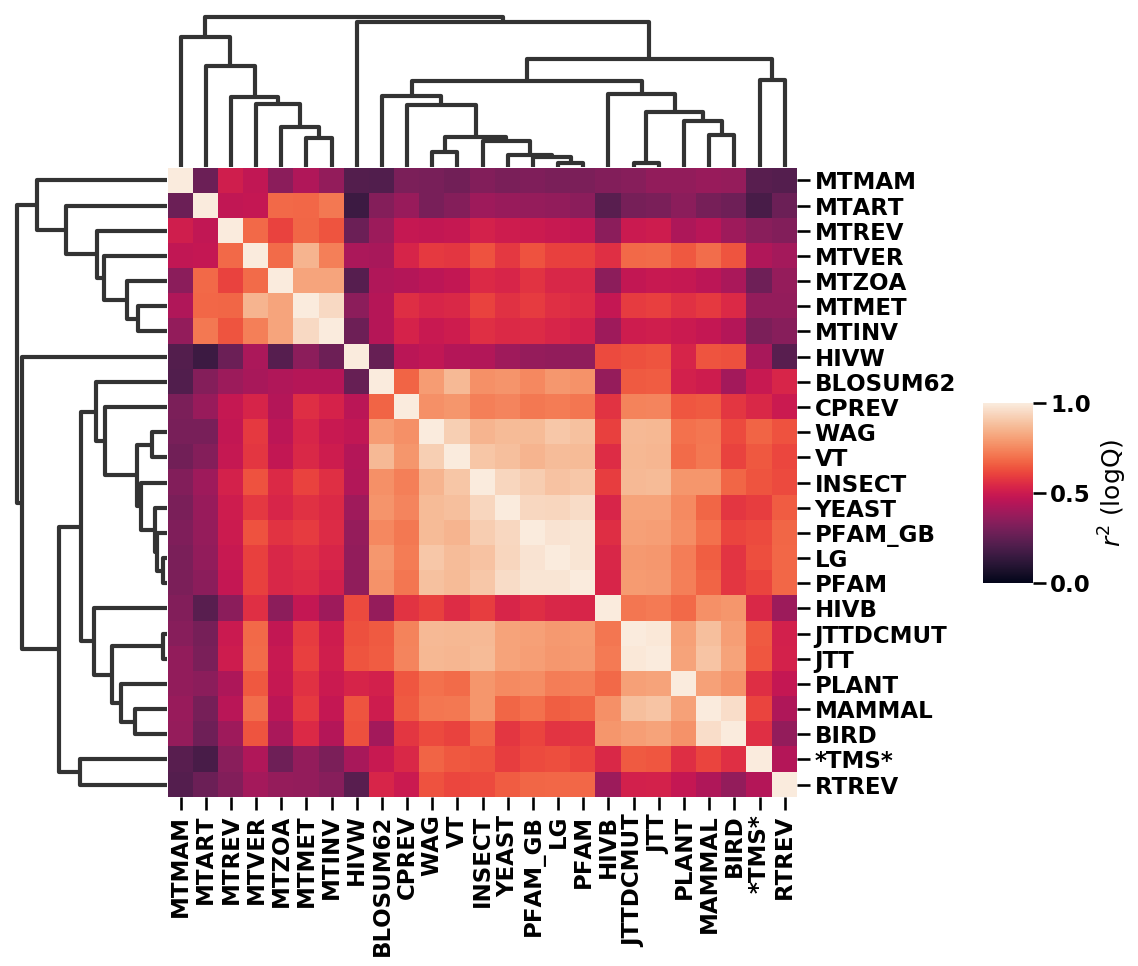

In [20]:
Qs = sorted(glob.glob('alternative_q_matrices/iqtree/F*dat'))
Qs = np.array([q for q in Qs if q not in ['alternative_q_matrices/iqtree/F20.dat',
                                 'alternative_q_matrices/iqtree/F2.dat',
                                 'alternative_q_matrices/iqtree/F1.dat',
                                 'alternative_q_matrices/iqtree/F3.dat',
                                 'alternative_q_matrices/iqtree/F16.dat']])

def r2_from_qi_qj(qi_f, qj_f, is_log=True):
    R_i, pi_i, Q_i, name_i = read_paml_ratemat_file(qi_f)
    Q_i = np.array([Q_i[i,j] for i in range(0,20) for j in range(0,20) if i!=j])
    Q_i = np.log(Q_i) if is_log else Q_i
    
    R_j, pi_j, Q_j, name_j = read_paml_ratemat_file(qj_f)
    Q_j = np.array([Q_j[i,j] for i in range(0,20) for j in range(0,20) if i!=j])
    Q_j = np.log(Q_j) if is_log else Q_j
    
    r2 = pearsonr(Q_j, Q_i)[0]**2
    return r2, name_i, name_j

# Get R2 vs TMS
q_i = 'alternative_q_matrices/iqtree/F0.dat'
R2s = []
for j, q_j in enumerate(Qs):
    R2s.append(r2_from_qi_qj(q_i, q_j)[0])
R2s = np.array(R2s)
reorder_idxes = (-R2s).argsort()

is_log = True
names = []
similarity = np.zeros((len(Qs),len(Qs)))
for i, q_i in enumerate(Qs[reorder_idxes]):
    for j, q_j in enumerate(Qs[reorder_idxes]):
        r2, name_i, name_j = r2_from_qi_qj(q_i, q_j, is_log=is_log)
        similarity[i,j] = r2
        if name_i not in names:
            names.append(name_i)

names = ['*TMS*' if 'QOSTED' in n else n for n in names]


names = np.array(names)
sns.set_context('talk')
lbl = '(logQ)' if is_log else '(Q)'
g = sns.clustermap(similarity, xticklabels=names,  yticklabels=names, 
               cbar_kws=dict(label = f'$r^2$ {lbl}'),
               cbar_pos=(1, 0.4, 0.05, 0.18),
               vmin=0, vmax=1,
               tree_kws={'linewidth':3})

df_similarity = pd.DataFrame(data=similarity, columns=names, index=names)
lbl = 'log_true' if is_log else 'log_false'
df_similarity.to_csv(f'out/r2s_for_q_vs_q_{lbl}.csv')

#fig = g.get_figure()
plt.tight_layout()
lbl = 'log_true' if is_log else 'log_false'
plt.savefig(f'figs/heatmap_Q_{lbl}.pdf', transparent=True)

In [21]:
R2s_no_MTs_no_QOSTED = []
R2s_yes_MTs_no_QOSTED = []
for lbl1 in names:
    for lbl2 in names:
        if lbl1==lbl2:
            continue
        if 'TMS' in lbl1 or 'TMS' in lbl2:
            continue
        if 'MT' in lbl1 or 'MT' in lbl2:
            R2s_yes_MTs_no_QOSTED.append(df_similarity[lbl1][lbl2])
        else:
            R2s_no_MTs_no_QOSTED.append(df_similarity[lbl1][lbl2])

col_QOSTED_all = [df_similarity['*TMS*'][n] for n in names if ('TMS' not in n)]
col_QOSTED_no_MT = [df_similarity['*TMS*'][n] for n in names if ('TMS' not in n and 'MT' not in n)]

ld = [R2s_no_MTs_no_QOSTED, R2s_yes_MTs_no_QOSTED, col_QOSTED_all,col_QOSTED_no_MT]
labels = ['all_vs_all_exclude_QOSTED_exclude_MTs', 'all_vs_all_exclude_QOSTED_include_MTs', 'QOSTED_vs_all' ,'QOSTED_vs_all_exclude_MTs']

make_plots = False
for d, l in zip(ld, labels):
    if make_plots:
        sns.distplot(d, label=l)
    lcorr = l.replace('QOSTED','TMS')
    print(f'{lcorr}: μ:{np.round(np.mean(d),2)} σ: {np.round(np.std(d),2)}')

if make_plots:
    plt.legend()
    plt.tight_layout()


all_vs_all_exclude_TMS_exclude_MTs: μ:0.7 σ: 0.17
all_vs_all_exclude_TMS_include_MTs: μ:0.47 σ: 0.14
TMS_vs_all: μ:0.5 σ: 0.14
TMS_vs_all_exclude_MTs: μ:0.58 σ: 0.07


# Compare R matrices

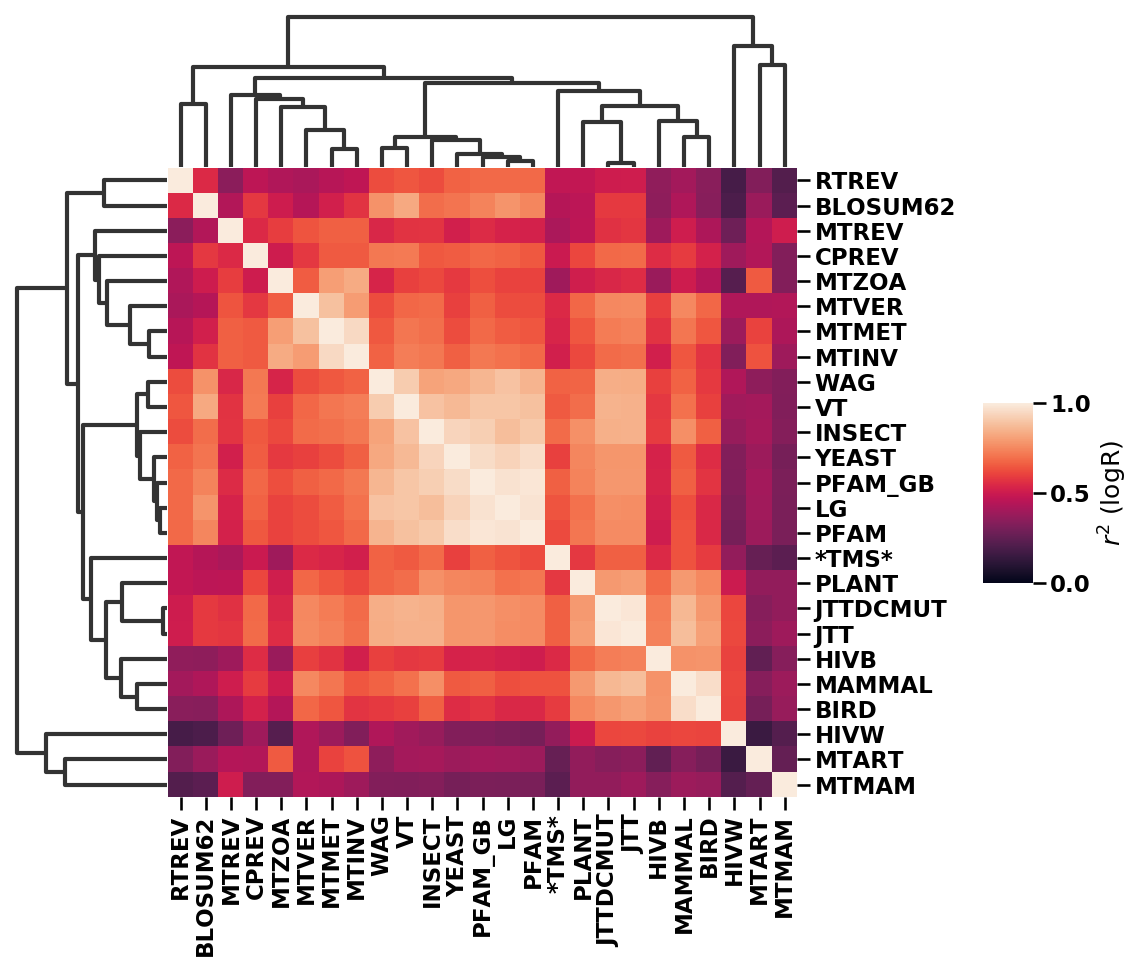

In [22]:
Qs = sorted(glob.glob('alternative_q_matrices/iqtree/F*dat'))
Qs = np.array([q for q in Qs if q not in ['alternative_q_matrices/iqtree/F20.dat',
                                 'alternative_q_matrices/iqtree/F2.dat',
                                 'alternative_q_matrices/iqtree/F1.dat',
                                 'alternative_q_matrices/iqtree/F3.dat',
                                 'alternative_q_matrices/iqtree/F16.dat']])

def r2_from_qi_qj(qi_f,qj_f, is_log=True):
    R_i, pi_i, Q_i, name_i = read_paml_ratemat_file(qi_f)
    R_i = np.array([R_i[i,j] for i in range(0,20) for j in range(i,20) if i!=j])
    R_j, pi_j, Q_j, name_j = read_paml_ratemat_file(qj_f)
    R_j = np.array([R_j[i,j] for i in range(0,20) for j in range(i,20) if i!=j])
    
    R_j = np.log(R_j) if is_log else R_j
    R_i = np.log(R_i) if is_log else R_i
    r2 = pearsonr(R_j, R_i)[0]**2

    return r2, name_i, name_j

# Get R2 vs QOSTED
q_i = 'alternative_q_matrices/iqtree/F0.dat'
R2s = []
for j, q_j in enumerate(Qs):
    R2s.append(r2_from_qi_qj(q_i, q_j)[0])
R2s = np.array(R2s)
reorder_idxes = (-R2s).argsort()


is_log = True
names = []
similarity = np.zeros((len(Qs),len(Qs)))
for i, q_i in enumerate(Qs[reorder_idxes]):
    for j, q_j in enumerate(Qs[reorder_idxes]):
        r2, name_i, name_j = r2_from_qi_qj(q_i, q_j, is_log=is_log)
        similarity[i,j] = r2
        if name_i not in names:
            names.append(name_i)
            
names = ['*TMS*' if 'QOSTED' in n else n for n in names]
names = np.array(names)
sns.set_context('talk')
lbl = '(logR)' if is_log else '(R)'
sns.clustermap(similarity, xticklabels=names,  yticklabels=names, 
               cbar_kws=dict(label = f'$r^2$ {lbl}'),
               cbar_pos=(1, 0.4, 0.05, 0.18),
               vmin=0, vmax=1,
               tree_kws={'linewidth':3})

df_similarity = pd.DataFrame(data=similarity, columns=names, index=names)
lbl = 'log_true' if is_log else 'log_false'
df_similarity.to_csv(f'out/r2s_for_R_vs_R_{lbl}.csv')

plt.savefig(f'figs/heatmap_R_{lbl}.pdf', transparent=True)

In [23]:
R2s_no_MTs_no_QOSTED = []
R2s_yes_MTs_no_QOSTED = []
for lbl1 in names:
    for lbl2 in names:
        if lbl1==lbl2:
            continue
        if 'TMS' in lbl1 or 'TMS' in lbl2:
            continue
        if 'MT' in lbl1 or 'MT' in lbl2:
            R2s_yes_MTs_no_QOSTED.append(df_similarity[lbl1][lbl2])
        else:
            R2s_no_MTs_no_QOSTED.append(df_similarity[lbl1][lbl2])

col_QOSTED_all = [df_similarity['*TMS*'][n] for n in names if ('TMS' not in n)]
col_QOSTED_no_MT = [df_similarity['*TMS*'][n] for n in names if ('TMS' not in n and 'MT' not in n)]
col_QOSTED_only_MT = [df_similarity['*TMS*'][n] for n in names if ('TMS' not in n and 'MT' in n)]

ld = [R2s_no_MTs_no_QOSTED, R2s_yes_MTs_no_QOSTED, col_QOSTED_all,col_QOSTED_no_MT, col_QOSTED_only_MT]
labels = ['all_vs_all_exclude_QOSTED_exclude_MTs', 'all_vs_all_exclude_QOSTED_include_MTs', 'QOSTED_vs_all' ,'QOSTED_vs_all_exclude_MTs', 'QOSTED_vs_MTs']

for d, l in zip(ld, labels):
    #sns.distplot(d, label=l)
    lcorr = l.replace('QOSTED','TMS')
    print(f'{lcorr}: μ:{np.round(np.mean(d),2)} σ: {np.round(np.std(d),2)}')

#plt.legend()
#plt.tight_layout()




all_vs_all_exclude_TMS_exclude_MTs: μ:0.68 σ: 0.18
all_vs_all_exclude_TMS_include_MTs: μ:0.52 σ: 0.16
TMS_vs_all: μ:0.54 σ: 0.13
TMS_vs_all_exclude_MTs: μ:0.59 σ: 0.09
TMS_vs_MTs: μ:0.42 σ: 0.12


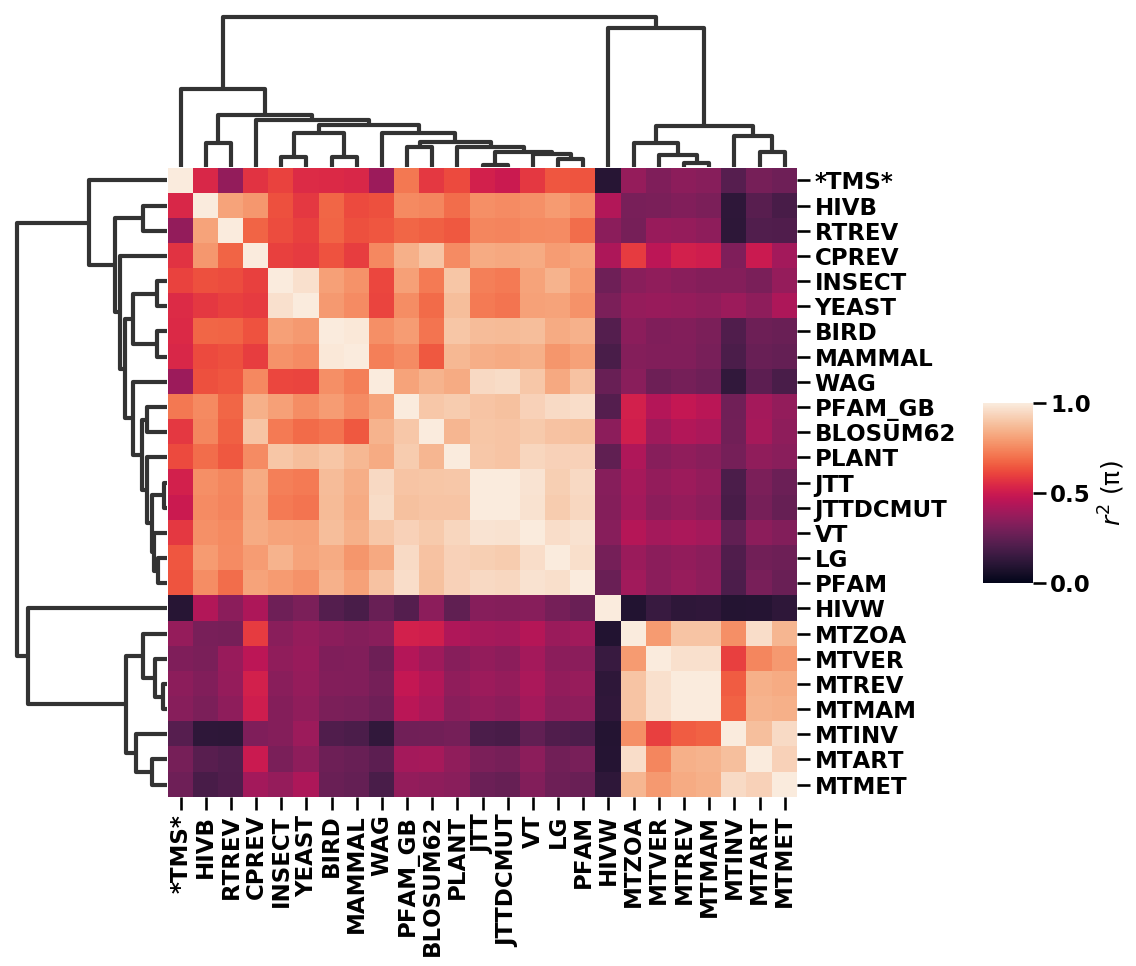

In [24]:
Qs = sorted(glob.glob('alternative_q_matrices/iqtree/F*dat'))
Qs = np.array([q for q in Qs if q not in ['alternative_q_matrices/iqtree/F20.dat',
                                 'alternative_q_matrices/iqtree/F2.dat',
                                 'alternative_q_matrices/iqtree/F1.dat',
                                 'alternative_q_matrices/iqtree/F3.dat',
                                 'alternative_q_matrices/iqtree/F16.dat']])

def r2_from_qi_qj(qi_f,qj_f, is_log=False):
    R_i, pi_i, Q_i, name_i = read_paml_ratemat_file(qi_f)
    R_i = np.array([R_i[i,j] for i in range(0,20) for j in range(i,20) if i!=j])
    R_j, pi_j, Q_j, name_j = read_paml_ratemat_file(qj_f)
    R_j = np.array([R_j[i,j] for i in range(0,20) for j in range(i,20) if i!=j])
    pi_i = np.log(pi_i) if is_log else pi_i
    pi_j = np.log(pi_j) if is_log else pi_j
    r2_pi = pearsonr(pi_i, pi_j)[0]**2
    return r2_pi, name_i, name_j

# Get pi vs QOSTED
q_i = 'alternative_q_matrices/iqtree/F0.dat'
R2s = []
for j, q_j in enumerate(Qs):
    R2s.append(r2_from_qi_qj(q_i, q_j)[0])
R2s = np.array(R2s)
reorder_idxes = (-R2s).argsort()

is_log = False
names = []
similarity = np.zeros((len(Qs),len(Qs)))
for i, q_i in enumerate(Qs[reorder_idxes]):
    for j, q_j in enumerate(Qs[reorder_idxes]):
        r2, name_i, name_j = r2_from_qi_qj(q_i, q_j, is_log=is_log)
        similarity[i,j] = r2
        if name_i not in names:
            names.append(name_i)
names = ['*TMS*' if 'QOSTED' in n else n for n in names]
names = np.array(names)
sns.set_context('talk')
lbl = '(logπ)' if is_log else '(π)'
sns.clustermap(similarity, xticklabels=names,  yticklabels=names, 
               cbar_kws=dict(label = f'$r^2$ {lbl}'),
               cbar_pos=(1, 0.4, 0.05, 0.18),
               vmin=0, vmax=1,
               tree_kws={'linewidth':3})
lbl = 'log_true' if is_log else 'log_false'
df_similarity = pd.DataFrame(data=similarity, columns=names, index=names)
df_similarity.to_csv(f'out/r2s_for_PI_vs_PI_{lbl}.csv')

plt.savefig(f'figs/heatmap_pi_{lbl}.pdf', transparent=True)

In [25]:
R2s_no_MTs_no_QOSTED = []
R2s_yes_MTs_no_QOSTED = []
for lbl1 in names:
    for lbl2 in names:
        if lbl1==lbl2:
            continue
        if 'QOSTED' in lbl1 or 'QOSTED' in lbl2:
            continue
        if 'MT' in lbl1 or 'MT' in lbl2:
            R2s_yes_MTs_no_QOSTED.append(df_similarity[lbl1][lbl2])
        else:
            R2s_no_MTs_no_QOSTED.append(df_similarity[lbl1][lbl2])

col_QOSTED_all = [df_similarity['*TMS*'][n] for n in names if ('TMS' not in n)]
col_QOSTED_no_MT = [df_similarity['*TMS*'][n] for n in names if ('TMS' not in n and 'MT' not in n)]
col_QOSTED_only_MT = [df_similarity['*TMS*'][n] for n in names if ('TMS' not in n and 'MT' in n)]

ld = [R2s_no_MTs_no_QOSTED, R2s_yes_MTs_no_QOSTED, col_QOSTED_all,col_QOSTED_no_MT, col_QOSTED_only_MT]
labels = ['all_vs_all_exclude_QOSTED_exclude_MTs', 'all_vs_all_exclude_QOSTED_include_MTs', 'QOSTED_vs_all' ,'QOSTED_vs_all_exclude_MTs', 'QOSTED_vs_MTs']

make_plots=False
for d, l in zip(ld, labels):
    lcorr = l.replace('QOSTED','TMS')
    if make_plots:
        sns.distplot(d, label=lcorr)
    print(f'{lcorr}: μ:{np.round(np.mean(d),2)} σ: {np.round(np.std(d),2)}')

if make_plots:
    plt.legend()
    plt.tight_layout()




all_vs_all_exclude_TMS_exclude_MTs: μ:0.72 σ: 0.2
all_vs_all_exclude_TMS_include_MTs: μ:0.4 σ: 0.21
TMS_vs_all: μ:0.47 σ: 0.15
TMS_vs_all_exclude_MTs: μ:0.53 σ: 0.14
TMS_vs_MTs: μ:0.31 σ: 0.05


# Plot Q inferred from 52 alignments (LG*) vs. LG

----------------------------------------------------------------------------------
LG
Q-matrix correlation 0.9701445606884411
R-matrix correlation 0.9678639858200204
pi-matrix correlation 0.7700565452940704


<Figure size 640x480 with 0 Axes>

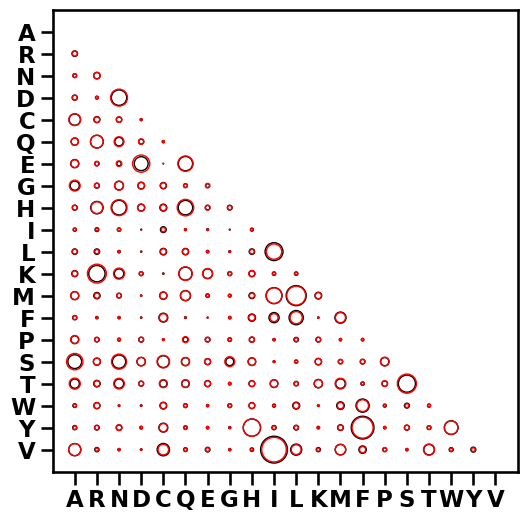

In [26]:
# Bubble plot
best_q = f'ReplacementMatrix/ReplacementMatrix.paml'
fit_R, fit_pi, fit_Q, _ = read_paml_ratemat_file(best_q)

native_matrix_fs = ['alternative_q_matrices/iqtree/F26.dat']
native_matrix_names = ['LG']
for q_f, q_name in zip(native_matrix_fs, native_matrix_names):
    LG_R, LG_pi, LG_Q, _ = read_paml_ratemat_file(q_f)
    plt.figure()
    figure(figsize=(6, 6))
    # Plot bubbles
    print('----------------------------------------------------------------------------------')
    print(q_name)
    plot_matrix(fit_R, set_color='black', half_matrix=True)
    plot_matrix(LG_R, set_color='red', half_matrix=True)
    #sns.despine()
    plt.savefig(f'figs/LG_vs_pfamLG_R.pdf', dpi=300)
    
    # Get correlations
    half_fit_Q = [fit_Q[i,j] for i in range(0,20) for j in range(0,20) if i!=j]
    half_LG_Q = [LG_Q[i,j] for i in range(0,20) for j in range(0,20) if i!=j]
    
    half_fit_R = [fit_R[i,j] for i in range(0,20) for j in range(i,20) if i!=j]
    half_LG_R = [LG_R[i,j] for i in range(0,20) for j in range(i,20) if i!=j]
    
    print(f'Q-matrix correlation {pearsonr(np.log(half_fit_Q), np.log(half_LG_Q))[0]**2}')
    print(f'R-matrix correlation {pearsonr(np.log(half_fit_R), np.log(half_LG_R))[0]**2}')
    print(f'pi-matrix correlation {pearsonr(LG_pi, fit_pi)[0]**2}')

0.9678639858200204


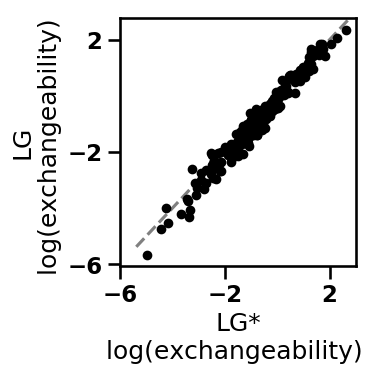

In [27]:
# Plot correlation for R
native_matrix_fs = ['alternative_q_matrices/iqtree/F26.dat']
native_matrix_names = ['LG']
is_log = True
for q_f, q_name in zip(native_matrix_fs, native_matrix_names):
    LG_R, LG_pi, LG_Q, _ = read_paml_ratemat_file(q_f)
    
    half_fit_R = [fit_R[i,j] for i in range(0,20) for j in range(i,20) if i!=j]
    half_LG_R = [LG_R[i,j] for i in range(0,20) for j in range(i,20) if i!=j]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    half_fit_R = np.log(half_fit_R) if is_log else half_fit_R
    half_LG_R = np.log(half_LG_R) if is_log else half_LG_R
    lbl = 'log(exchangeability)' if is_log else 'exchangeability'
    ax.scatter(half_fit_R, half_LG_R, color='black', s=30, zorder=10)
    add_identity(ax, color='grey', ls='--', zorder=0)
    plt.xlabel(f'LG*\n{lbl} ')
    plt.ylabel(f'LG\n{lbl} ')
    plt.minorticks_off()
    plt.yticks([-6,-2,2])
    plt.xticks([-6,-2,2])
    plt.tight_layout()
    sns.set_context('talk')
    
    plt.savefig(f'figs/LG_vs_pfamLG_R_scatter.pdf', transparent=True, dpi=300)
    
    print(pearsonr(half_fit_R, half_LG_R)[0]**2)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


0.7700565452940704


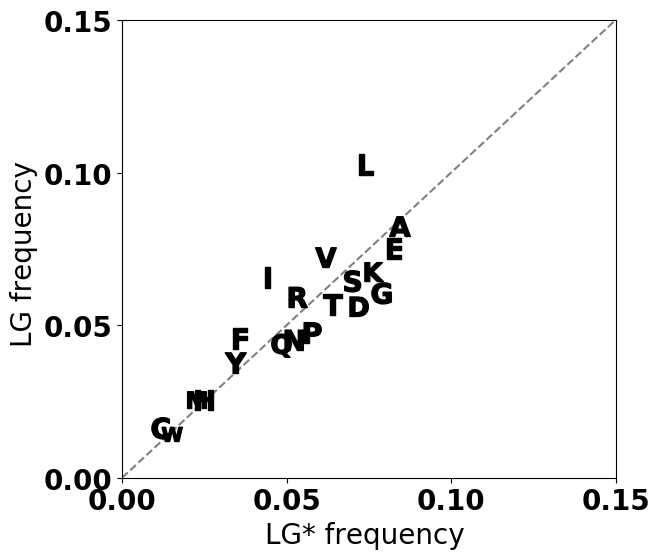

In [28]:
# plot correlations for pi
mpl.rcdefaults()

font = {'family': 'normal',
        'weight': 'bold',
        'size': 20}
mpl.rc('font', **font)
from matplotlib.text import TextPath
aas = 'ARNDCQEGHILKMFPSTWYV'

for q_f, q_name in zip(native_matrix_fs, native_matrix_names):
    LG_R, LG_pi, LG_Q, _ = read_paml_ratemat_file(q_f)
    fig, ax = plt.subplots(figsize=(7, 6))
    
    for i,aa in enumerate(list(aas)):
        p = TextPath((0,0), aa)
        ax.plot(fit_pi[i], LG_pi[i],
                   zorder=10, 
                   marker=p, markersize=30, color='black') # marker=r"$ {} $".format(aa)
    add_identity(ax, color='grey', ls='--', zorder=0)
    plt.xlim([0, 0.15])
    plt.ylim([0, 0.15])
    y_ticks = plt.yticks([0,0.05,0.10,0.15])
    x_ticks = plt.xticks([0,0.05,0.10,0.15])
    
    
    plt.xlabel('LG* frequency ')
    plt.ylabel(f'LG frequency ')
    plt.tight_layout()

    plt.savefig(f'figs/LG_vs_pfamLG_pi.pdf', transparent=True)
    print(pearsonr(fit_pi, LG_pi)[0]**2)